# Homework 4

**Name:**

In [34]:
Name = "Chance Gunter"
assert Name != "", 'Please enter your name in the above quotation marks, thanks!'

In this homework, we will train a CNN model to classify big cats. This dataset consists of images of ten types of big cats, a.k.a, multiclass classification.

 **Please download the dataset from the [inclass Kaggle competition](https://www.kaggle.com/t/e5a7bab3f6c543a9943b3d9970768eaa) as we split the original dataset into the train-valid-test sets.**

This notebook contains a baseline model. Please use it as a starting point. **The purpose of this homework is to design an advanced CNN model to achieve better performance by yourself. You are not allowed to import pre-trained models. In case you are interested, we provide a sample code by using a pre-trained model, Resnet50.**

Your jobs

-   Read, complete, and run the code.

-   **Make substantial improvements** to maximize the accurcy.

-   Submit the .IPYNB file to Canvas.

    - Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`.
    
    - Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
    
    - Please keep your notebook clean and delete any throwaway code.

-   Submit the generated "pred.csv" to the [inclass Kaggle competition](https://www.kaggle.com/t/e5a7bab3f6c543a9943b3d9970768eaa).


# **Rules**

- You should finish your homework on your own.
- **You should not modify your prediction files manually.**
- Do not share code or prediction files with any living creatures.
- **Do not search or use additional data.**
- **Do not use any pre-trained models.**
    - You can ask Github copilot for help.


## Hints to Improve Your Results

* You'd better use a GPU machine to run it, otherwise it'll be quite slow.
* Revise the simple CNN model
* Revise the *transforms* function by using some image augumentation techniques
* Tune hyper-parameters, such as batch_size

First, import the packages or modules required for the competition.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import shutil
import time
from copy import deepcopy

device = 'cuda'
import torchvision.models as models

original_path = r'local_path'
os.chdir(original_path)

In [38]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

### Download the dataset to Colab from Kaggle.

**You need to have your Kaggle Token at hand**. Please find [this article](https://medium.com/@opalkabert/downloading-kaggle-datasets-into-google-colab-fb9654c94235) for details.

In [39]:
from google.colab import files
files.upload()   ## Upload your Kaggle token file.

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"downtowndrizzle","key":"735fad8be80c67ea6e01721e3564cf4a"}'}

In [40]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c fall2023-cs5665-hw4   ## You need to join the competition first.

fall2023-cs5665-hw4.zip: Skipping, found more recently modified local copy (use --force to force download)


In [41]:
import os
import zipfile
from pathlib import Path
local_zip = 'fall2023-cs5665-hw4.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

### Loading and normalizing

Using torchvision, it’s extremely easy to load the dataset.

In [42]:
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=(64, 64)),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    # Add more transformations as needed
])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train images: 2111, val images: 50, test images: 278
trainset = torchvision.datasets.ImageFolder(root='./Dataset/train', transform=transform)
valset = torchvision.datasets.ImageFolder(root='./Dataset/val', transform=transform)
testset = torchvision.datasets.ImageFolder(root='./Dataset/test', transform=transform)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = (os.listdir('./Dataset/train/'))
# print(trainloader.class_to_idx)

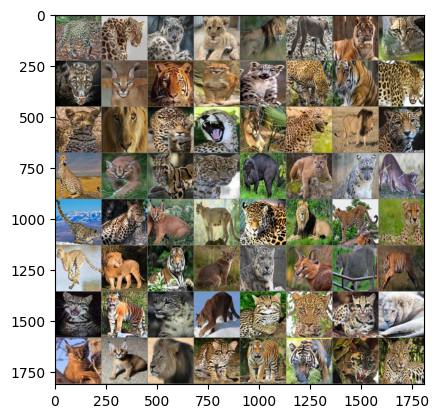

OCELOT JAGUAR SNOW LEOPARD LIONS


In [43]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define the Model

In [50]:
import torch.nn as nn
import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.batchnorm1 = nn.BatchNorm2d(6)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.batchnorm2 = nn.BatchNorm2d(16)
#         self.flatten = nn.Flatten()
#         self.dropout = nn.Dropout(.4)
#         self.fc1 = nn.Linear(16 * 53 * 53, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
#         x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
#         x = self.flatten(x)
#         # x = x.view(-1, 16 * 53 * 53)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = self.fc3(x)
#         return x

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out1x1, red3x3, out3x3, red5x5, out5x5, out1x1pool):
        super(InceptionBlock, self).__init__()

        # 1x1 convolution
        self.branch1 = nn.Conv2d(in_channels, out1x1, kernel_size=1)

        # 1x1 convolution followed by 3x3 convolution
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red3x3, kernel_size=1),
            nn.Conv2d(red3x3, out3x3, kernel_size=3, padding=1)
        )

        # 1x1 convolution followed by 5x5 convolution
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red5x5, kernel_size=1),
            nn.Conv2d(red5x5, out5x5, kernel_size=5, padding=2)
        )

        # 3x3 max pooling followed by 1x1 convolution
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out1x1pool, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        # Concatenate along the channel dimension
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, dim=1)

class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=1)

        # Inception blocks
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)

        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1)

        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)

        self.maxpool4 = nn.MaxPool2d(3, stride=2, padding=1)

        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.maxpool1(F.relu(self.conv1(x)))
        x = self.maxpool2(F.relu(self.conv2(x)))

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

In [51]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

## Define the Training Functions

We will select the model and tune hyper-parameters according to the model's performance on the validation set. Next, we define the model training function `train`. We record the training time of each epoch, which helps us compare the time costs of different models.

In [ ]:
%%time
best_val_acc = -1000
best_val_model = None
num_samples = 5

for epoch in range(20):
  nets = [Net().to(device) for _ in range(num_samples)]

    # Training with bootstrap samples
  for i in range(num_samples):
      net_i = deepcopy(net)
      net_i.train()
      running_loss = 0.0
      running_acc = 0

      for data in trainloader:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = net_i(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          out = torch.argmax(outputs.detach(), dim=1)
          assert out.shape == labels.shape
          running_acc += (labels == out).sum().item()

      print(f"Train loss {epoch + 1}: {running_loss / len(trainset)}, Train Acc:{running_acc * 100 / len(trainset)}%")

  # Validation
  correct = 0
  net.eval()
  with torch.no_grad():
      for inputs, labels in valloader:
          out = net(inputs.to(device)).cpu()
          out = torch.argmax(out, dim=1)
          acc = (out == labels).sum().item()
          correct += acc

  print(f"Val accuracy:{correct * 100 / len(valset)}%")

  # Save the best model
  if correct > best_val_acc:
      best_val_acc = correct
      best_val_model = deepcopy(net.state_dict())

  lr_scheduler.step()

print('Finished Training')

In [ ]:
%%time
preds = []
net.load_state_dict(best_val_model)
net.eval()
with torch.no_grad():
    for inputs,labels in testloader:
        out = net(inputs.cuda()).cpu()
        out = torch.argmax(out,dim=1)
        preds.append(out.detach().cpu())
preds = torch.cat(preds, dim=0).numpy()

In [48]:
import csv
with open('pred.csv', 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'label'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])